# This code will train the model and save weights  using a data generator

First Import libraries

In [2]:
import os
import numpy as np
import keras
import tensorflow
from sklearn.model_selection import train_test_split
import nibabel as nib
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

In [3]:
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Define our Data Generator and other functions to be used later

In [4]:
from Data_Gen_Mask import DataGeneratorWMask 

In [5]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

In [6]:
def gather_set_and_path(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(str(data_path+f))
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

Define the paths where images and segmentations are located. Gather into groups and arrange into a dictionary that can be split up for training, testing, and validation for the model

## Expected Dimmentions

Image: (512,512) range: 0:255

Label: (512,512) range: 0:1

In [7]:
#data_path_1 = r"C:\Users\UAB\data\KU\data\\"
#data_path_2 = r"C:\Users\UAB\data\Mayo\data\\"
data_path_3 = r"C:\Users\UAB\data\Emory\data\\"
data_path_4 = r"C:\Users\UAB\data\UAB\data\\"

#images_1 = gather_set_and_path(data_path_1, '_M')
#images_2 = gather_set_and_path(data_path_2, '_M')
images_3 = gather_set_and_path(data_path_3, '_M')
images_4 = gather_set_and_path(data_path_4, '_M')


#images = images_1+images_2+images_3+images_4
images = images_3+images_4

print(len(images))



30766


In [8]:
#print(len(images_1))
#print(len(images_2))
print(len(images_3))
print(len(images_4))


23488
7278


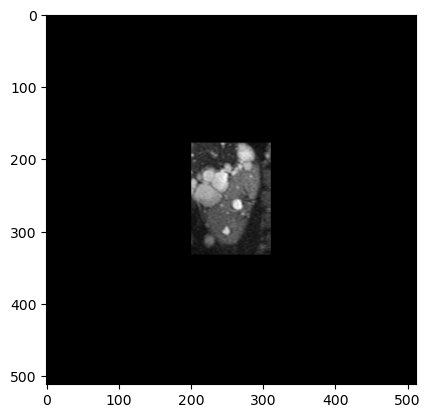

In [9]:
%matplotlib inline

image = np.load(images[-1500])
plt.imshow(image, cmap='gray')

In [10]:
#masks_1 = gather_set_and_path(data_path_1, '_K')
#masks_2 = gather_set_and_path(data_path_2, '_K')
masks_3 = gather_set_and_path(data_path_3, '_K')
masks_4 = gather_set_and_path(data_path_4, '_K')

#masks = masks_1 + masks_2 + masks_3 + masks_4
masks = masks_3 + masks_4
print(len(masks))

30766


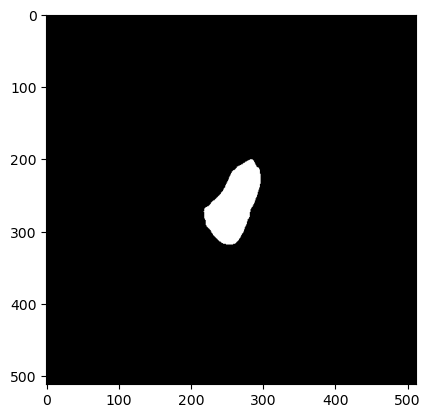

In [11]:
mask = np.load(masks[-1500])
plt.imshow(mask, cmap='gray')

In [55]:
#labels_1 = gather_set_and_path(data_path_1, '_C')
#labels_2 = gather_set_and_path(data_path_2, '_C')
labels_3 = gather_set_and_path(data_path_3, '_C')
labels_4 = gather_set_and_path(data_path_4, '_C')

#labels = labels_1 + labels_2 + labels_3 + labels_4
labels = labels_3 + labels_4
print(len(labels))


30766


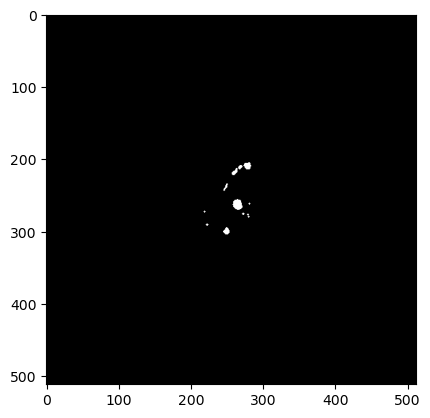

In [56]:
label = np.load(labels[-1500])
plt.imshow(label, cmap='gray')

In [60]:
print(masks[-1500])
print(images[-1500])
print(labels[-1500])
test_img = np.load(images[100])
print(test_img.shape, test_img.max(), test_img.min())
test_msk = np.load(masks[100])
print(test_msk.shape, test_msk.max(), test_msk.min())
test_lab = np.load(labels[100])
print(test_lab.shape, test_lab.max(), test_lab.min())


C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_K.npy
C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_M.npy
C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_C.npy
(512, 512) 129 0
(512, 512) 1 0
(512, 512) 1 0


## Define Image and Label ID for data generator

Here the "test train split" will need to be replaced so we have the whole patient in one or the other"


In [15]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [16]:
print(len(labels))

30766


In [17]:
import os
img_name = os.path.basename(images[0])[0:11]
print(img_name)

EM_200922_0


Image separation for entire patient in training or validation - use with single set of images


In [18]:
from sklearn.model_selection import train_test_split


id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:11]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [19]:
print(len(unique_ids))

143


In [20]:
train, val = train_test_split(unique_ids, train_size = 0.8)

In [21]:
print(len(train))
print(len(val))

114
29


In [22]:
print(train[0:2])

['UB_457036_1', 'EM_242715_1']


In [23]:
#use this when images do not contain filepath:
#train_list = [image for image in images if image[0:8] in train]
#val_list = [image for image in images if image[0:8] in val] 

In [24]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train):
        train_list.append(images[i])

In [25]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val):
        val_list.append(images[i])

In [26]:
print(len(train_list))
print(len(val_list))
print(len(train_list)+len(val_list))
print(len(images))

24408
6358
30766
30766


In [27]:
partition = {'train':train_list, 'validation':val_list}

In [27]:
import csv
with open('dict.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in partition.items():
       writer.writerow([key, value])

In [29]:
with open('training.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(train_list)


In [38]:
import csv
from itertools import zip_longest
list1 = train_list
list2 = val_list
d = [list1, list2]
export_data = zip_longest(*d, fillvalue = '')
with open('training_validation.csv', 'w', newline='') as myfile:
      wr = csv.writer(myfile)
      wr.writerow(("Training", "Validation"))
      wr.writerows(export_data)
myfile.close()

In [41]:
from pandas import *
 
# reading CSV file
data = read_csv("training_validation.csv")
 
# converting column data to list
train = data['Training'].tolist()
val = data['Validation'].tolist()

In [42]:
print(len(train_list))
print(len(val_list))
print(len(train))
print(len(val))

60755
15984
60755
60755


## Use for crossfold validation:

In [49]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [11]:
train_sets = ['MA_', 'KU_', "EM_"]
val_sets = ["UB_"]

train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train_sets):
        train_list.append(images[i])


In [12]:
print(train_list[100])

C:\Users\UAB\Kidney-Segmentation-Jupyter\data\\KU_101934_1_96_R_13_M.npy


In [13]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val_sets):
        val_list.append(images[i])


In [14]:
print(val_list[100])

C:\Users\UAB\data\UAB\data\\UB_419258_0_11_L_9_M.npy


In [15]:
partition = {'train':train_list, 'validation':val_list}
print(len(train_list))
print(len(val_list))

66273
1081


# Create our data generators 

In [65]:
from Data_Gen_Mask import DataGeneratorWMask 
from Data_Gen import DataGenerator 

In [68]:
params = {'dim': (512,512),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

In [69]:
X,y = training_generator[8]
print(X.shape, y.shape)

(32, 512, 512, 1) (32, 512, 512, 2)


## View output

(512, 512) 207.0 0.0


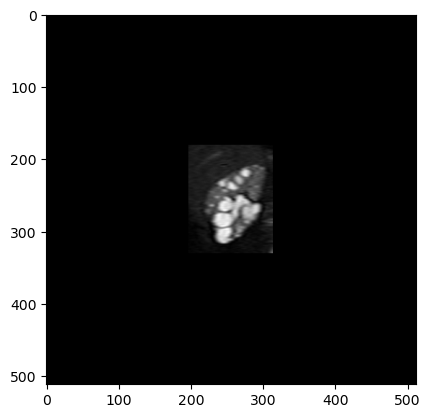

In [72]:
X_batch = X[20,:,:,:]
X_batch.shape
X_img = X_batch[:,:,0]
print(X_img.shape, X_img.max(), X_img.min())

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_img, cmap="gray")

(512, 512) 1.0 0.0


<Figure size 640x480 with 0 Axes>

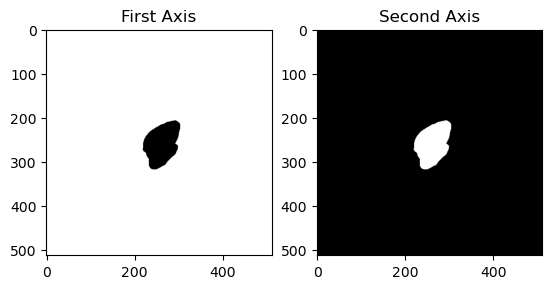

In [74]:
y_batch = y[20,:,:,:]
y_batch.shape
y_img_0 = y_batch[:,:,0]
y_img_1 = y_batch[:,:,1]
print(y_img_0.shape, y_img_0.max(), y_img_0.min())


plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(y_img_0, cmap="gray")
axarr[0].title.set_text('First Axis')
axarr[1].imshow(y_img_1, cmap='gray')
axarr[1].title.set_text('Second Axis')

In [44]:
X1, y1 = training_generator[20]
print(X1.shape)
print(y1.shape)

(32, 512, 512, 1)
(32, 512, 512, 2)


In [98]:
#params = {'dim': (512,512),
         # 'batch_size': 30,
         # 'n_classes': 2,
        #  'n_channels': 1,
        #  'shuffle': True}
#training_generator_2 = DataGenerator(partition['train'], labels, **params)
#validation_generator_2 = DataGenerator(partition['validation'], labels, **params)

In [45]:
model = custom_unet(input_shape=(512,512,1), num_classes=2)
#model.summary()

In [46]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
filepath = "ALL_INSTITUTION_80-20.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [47]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=jaccard_distance,
  metrics=[dice_coef])

In [48]:
# Train model on dataset
history = model.fit(training_generator, epochs = 10,
                    validation_data = validation_generator,
                    use_multiprocessing=False,
                    workers=6, batch_size = 32)

Epoch 1/10
1680/1680 [==============================] - 686s 403ms/step - loss: 0.2086 - dice_coef: 0.8950 - val_loss: 0.0224 - val_dice_coef: 0.9886
Epoch 2/10
1680/1680 [==============================] - 690s 410ms/step - loss: 0.0170 - dice_coef: 0.9914 - val_loss: 0.0095 - val_dice_coef: 0.9951
Epoch 3/10
1680/1680 [==============================] - 689s 410ms/step - loss: 0.0076 - dice_coef: 0.9961 - val_loss: 0.0060 - val_dice_coef: 0.9969
Epoch 4/10
1680/1680 [==============================] - 693s 412ms/step - loss: 0.0057 - dice_coef: 0.9971 - val_loss: 0.0049 - val_dice_coef: 0.9975
Epoch 5/10
1680/1680 [==============================] - 690s 410ms/step - loss: 0.0047 - dice_coef: 0.9976 - val_loss: 0.0045 - val_dice_coef: 0.9977
Epoch 6/10
1680/1680 [==============================] - 689s 410ms/step - loss: 0.0042 - dice_coef: 0.9979 - val_loss: 0.0044 - val_dice_coef: 0.9978
Epoch 7/10
1680/1680 [==============================] - 690s 410ms/step - loss: 0.0039 - dice_coef: 

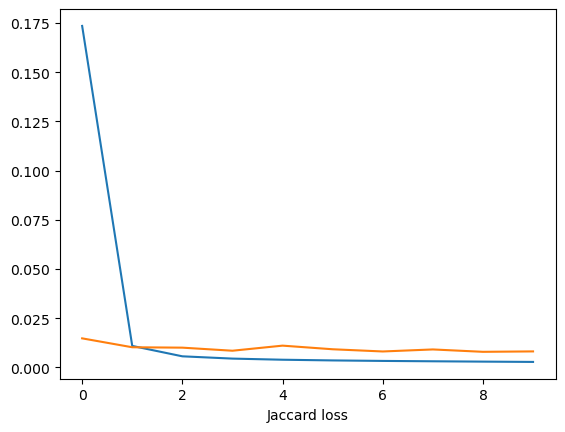

In [25]:
%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

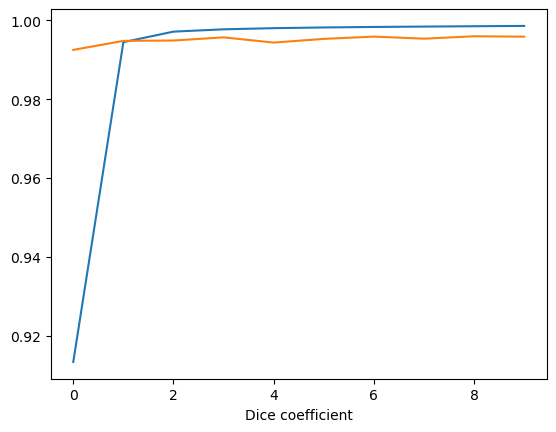

In [26]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')

In [49]:
from keras.models import Sequential, load_model
model.save( "ALL_INSTITUTION_80-20.h5")    